In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Nov 13 17:52:48 2024

@author: josep

Statistical OBAN

TODO. NEED TO FIX THE OBS INCREMENT GUY
"""
import numpy as np
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import haversine
import copy

In [2]:
# Top scope level variables
m= 1/15000000 # map scale value
rho = 6371*1000 # radius of earth in meters
phi0 = 60 # phi naught  - intersecting plane at 60 deg North
lamb0 = 245 # 245 degrees longitude West


In [3]:
def getData(mydatapath):
    with open(mydatapath) as f:
        myfile = f.read().splitlines() #splits by newlines 
        
    myfile = [x.split(",") for x in myfile] # list of lines split be delimiter
    
    newArr = [None for x in range(len(myfile))] # index for station tracking
    floatArr = np.zeros((135,6),dtype='float') # floating point conversion
    # watch out for  floating point comparison as station ids are floats 
    for i in range(len(myfile)):
        # list of dictionaries. One dict for each station
        newArr[i] = { "Station":myfile[i][0],
                     "Latitude":myfile[i][1],
                     "Longitude":myfile[i][2],
                     "500mb Height":myfile[i][3],
                     "500mb Wind Direction":myfile[i][4],
                     "500mb Wind Speed": myfile[i][5] }  
        floatArr[i][0] = i # loop var same as station index
        floatArr[i][1:] = [float(x) for x in myfile[i][1:]] 
        # convert rest of items in sub-list  from str to float and pass it to array
    return floatArr

#==============================================================================
# this function converts our lats/lons of observations to x-y space
def ConvertMapCoords(coordArray: list,phi0=60,lamb0= 245): # preferably a numpy.ndarray

    radCoord = coordArray[:,1:3].copy()
    radCoord[:,1] = radCoord[:,1] - lamb0
    radCoord = radCoord * np.pi/180.0
    
    sigma = lambda phi,phi0=60: (1+np.sin(phi0 * np.pi/180)) / (1 + np.sin(phi)) 
    
    dataX = rho*sigma(radCoord[:,0]) * np.cos(radCoord[:,0])*np.cos(radCoord[:,1])
    dataY = rho*sigma(radCoord[:,0]) * np.cos(radCoord[:,0])*np.sin(radCoord[:,1])
    # transform data by map factor and then put into cm
    # WHY DID I DO NEGATIVE DATAY HERE?
    # it was because i reversed a formula lol. 
    return np.stack((coordArray[:,0],dataX,dataY,coordArray[:,3]),axis=1)

#==============================================================================
#this converts our x/y grid to map space. Input is in IMAGE PLANE METERS
def convertXYtoLatLon(xnew1,ynew1):
    xnew1 = np.copy(xnew1)
    ynew1 = np.copy(ynew1)
    mapX  = 245 + np.arctan(ynew1/xnew1)*180/np.pi # our xy grid in lat/lon space
    arg1 = np.power(((xnew1)**2 + (ynew1)**2),0.5)
    arg2 = (rho*(1+np.sin(phi0*np.pi/180.)))
    mapY = (np.pi/2 - 2*np.arctan(arg1/arg2))*180/np.pi

    return [mapX,mapY]

#==============================================================================
def makeMyGrid(X0=18.90,Y0=-6.30):
    
    #X0 = 18.90 #cm # x start value
    #Y0 = -6.30 #cm # y start value
    
    # input must be in radians. Fancy lamba functions!     
    # Creation of our analysis grid in x-y space
    #x_grid = np.linspace(X0,X0+1.27*21,22)
    #y_grid = np.linspace(Y0,Y0+1.27*27,28) # keeping in cm for now
    x_grid = 18.9 + np.arange(22)*1.27
    y_grid = -6.30 + np.arange(28)*1.27
    #THIS DECREASES DOWNWARDS
    
    xnewO,ynewO = np.meshgrid(x_grid,y_grid) # this is our np.meshgrid
    xnewM = xnewO/100/m #convert to image plane
    ynewM = ynewO/100/m #convert to image plane
    return [xnewM,ynewM,xnewO,ynewO] # THIS WILL BE HUGE NUMBER IN METERS
    # O stands for Original cm, M stands for Meters
#==============================================================================
#==============================================================================
def getDminV3(stationMapSpace):
    stationMapSpace = np.copy(stationMapSpace) # since we're editing stuff
    stationList = stationMapSpace[:,1:3]*m*100 # we are in map space (cm) now
    distanceList = np.zeros(135)   

    for i in range(len(stationMapSpace)):
        arg = np.sqrt( (stationList[:,0] - stationList[i,0])**2 + \
                (stationList[:,1] - stationList[i,1])**2)
        this_min = np.min(arg[~np.isclose(arg,0.0)])
        distanceList[i] = this_min
            
    
    return np.mean(distanceList) # this is tne dmin distance in CENTIMETERS

#==============================================================================
def findCloseValues(xnew,ynew,stationMapSpace,radiusInfluence:float,isBackground:bool):
    filteredDict = []
    stationMapSpace = np.copy(stationMapSpace) # since we're editing stuff
    stationMapSpace[:,1:3] = stationMapSpace[:,1:3]*m*100 # we are in map space (cm) now
    numObsInRadius = np.zeros((28,22))

    # fun with lambda functions!         
    barnesWeight = lambda dik, kd=10.8844524: np.exp(-(dik**2) / kd )
        
    if isBackground: # if background
        for i in range(xnew.shape[0]):
            for j in range(xnew.shape[1]):
                #print(np.max(xnew),np.max(ynew))
                distanceFilter = np.sqrt( (xnew[i,j] - stationMapSpace[:,1])**2 + \
                (ynew[i,j] - stationMapSpace[:,2])**2)
    
                Weight = np.asarray([barnesWeight(x) for x in distanceFilter])
                Weight[distanceFilter > radiusInfluence] = 0
                
                newArr = np.column_stack((stationMapSpace,Weight))
                # the weight is in the last column. it used CM
                obsCount = np.count_nonzero(Weight)
                numObsInRadius[i,j] = np.count_nonzero(Weight)
                
                filteredDict.append({"x":i,"y":j,"filteredObs":copy.deepcopy(newArr),"numObs":obsCount})
    else:
        print("todo")
            
    # RETURN VALUE IS NOW IN CENTIMETERS SPACE!
    return [filteredDict,numObsInRadius]
#==============================================================================
def doPassOne(filteredDict,radiusInfluence:float):
        
    arg = copy.deepcopy(filteredDict) # just to be safe, made a copy
    firstPass = np.zeros((28,22))
    
    for this_arg in arg:
        xc = this_arg['x']
        yc = this_arg['y']    
        this_pass = np.sum(this_arg['filteredObs'][:,-1]*this_arg['filteredObs'][:,-2]) / np.sum(this_arg['filteredObs'][:,-1])
        firstPass[xc,yc] = this_pass
        
        if this_arg["numObs"] == 0:
            #firstPass[xc,yc] = np.nan
            #TODO this is for values that have no  points in the ROI.
            print("go check it!",xc,yc)
    return firstPass
#==============================================================================
#==============================================================================    
def doBilinearInterpolation(pt,wxField):
    # Lower Right, Upper Right, Upper Left, Lower Left, point
    # each of these is a numpy array of size 2, i.e. [x,y,z]. x/y/z are floats
    # x/y are the coords, and z is the value. 
    
    xgrid = 18.9 + np.arange(22)*1.27
    ygrid = -6.30 + np.arange(28)*1.27
    
    xcord = pt[0]
    ycord = pt[1]
    
        # this gives the INDEX of the things. 
    x1 = int(np.floor( (xcord - 18.9) / 1.27))
    x2 = int(np.ceil( (xcord - 18.9) / 1.27) )
    y1 = int(np.floor( (ycord - -6.30) / 1.27))
    y2 = int(np.ceil( (ycord - -6.30) / 1.27))
    
    if (pt[0] <18.9 or pt[0] > xgrid[-1] or pt[1] <-6.30 or pt[1] > ygrid[-1]):
        #print("darn")
        return np.nan
    # this gives the INDEX of the things. 
    x1 = int(np.floor( (xcord - 18.9) / 1.27))
    x2 = int(np.ceil( (xcord - 18.9) / 1.27) )
    y1 = int(np.floor( (ycord - -6.30) / 1.27))
    y2 = int(np.ceil( (ycord - -6.30) / 1.27))
    
    LL = [xgrid[x1],ygrid[y1],wxField.T[x1,y1]]
    LR = [xgrid[x2],ygrid[y1],wxField.T[x2,y1]]
    UL = [xgrid[x1],ygrid[y2],wxField.T[x1,y2]]
    UR = [xgrid[x2],ygrid[y2],wxField.T[x2,y2]]
    
    x1 = LL[0]
    x2 = LR[0]
    y1 = LL[1]
    y2 = UL[1]
    
    
    leftMatrix = np.matrix([ [1, x1, y1, x1*y1],
                 [1, x1, y2, x1*y2],
                 [1, x2, y1, x2*y1],
                 [1, x2 ,y2, x2*y2]])
    rightSide = np.matrix( [LL[2],UL[2],LR[2],UR[2] ] ).T
    leftMatrixInv = np.linalg.inv(leftMatrix)
    myArgs = leftMatrixInv @ rightSide
    ptArg = np.matrix( [ 1, pt[0],pt[1],pt[0]*pt[1] ] )
    result = ptArg @ myArgs
    numResult = result[0,0]
    #print("done")
    return numResult

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#==============================================================================
#==============================================================================
def AnalysisFile(filterDict,xnewCM,ynewCM,mapX,mapY,FinalAnalysisFile,
                 differenceField,ObsWanted,delim=","):
    header = ["i-index (unitless)","j-index (unitless)",
              "X-value (cm)","Y-value (cm)","Longitude (deg)", 
              "Latitude (deg)",
              "500mb Height Analysis (m)","Analysis Increment from Background (m)"]
    
    header = delim.join([str(x) for x in header])    
    
    # MAKE SURE THAT I AM WRITING ANALYSIS DIFFERENCES IN THE RIGHT WAY. 
    # MAKE SURE THAT IT IS FLATTENED IN THE RIGHT WAY. 
    logfile = []
    logfile.append(header)
    for i in range(len(filterDict)):
        thisrow = [0,0,0,0,0,0,0,0]
        
        tester = filterDict[i]
        if len(tester["filteredObs"]) == 0:
            #print("temp")
            pass
            #continue
        mypoint = [tester["x"], tester["y"] ]
        thisrow[0] = tester["x"]
        thisrow[1] = tester["y"]
        thisrow[2] = np.round(xnewCM[ tester["x"], tester["y"]],4)
        thisrow[3] = np.round( ynewCM[ tester["x"], tester["y"]],4)
        thisrow[4] = np.round(mapX[tester["x"], tester["y"]],4)
        thisrow[5] = np.round(mapY[tester["x"], tester["y"]],4)
        thisrow[6] = np.round(FinalAnalysisFile[tester["x"], tester["y"]],4)
        thisrow[7] = np.round(differenceField[tester["x"], tester["y"]],4)
        
        # delimiter is just a comma
        arg = delim.join([str(x) for x in thisrow])
        logfile.append(arg)
        
    logfile = "\n".join(logfile)
    newFilename = "Analysis" + "Obs_Num_Included" + str(ObsWanted) + ".csv"
    with open(newFilename, "w") as fileToWrite:
        fileToWrite.write(logfile)
        
    return [logfile,newFilename]

def stationInterpolations(thisFloatArr,interpolatedValues,ObsWanted,delim=","):
    header = ["stationID","latitude (deg)","longitude (deg)",
              "Observed 500 hPa geopotential height (m)",
              "Analyzed 500 hPa geopotential height (m)","Analysis - Observed (m)"]
    
    header = delim.join([str(x) for x in header])    
    
    # MAKE SURE THAT I AM WRITING ANALYSIS DIFFERENCES IN THE RIGHT WAY. 
    # MAKE SURE THAT IT IS FLATTENED IN THE RIGHT WAY. 
    logfile = []
    logfile.append(header)
    for i in range(len(thisFloatArr)):
        thisrow = [0,0,0,0,0,0]
        
        thisrow[0] = np.round(thisFloatArr[i][0],0)
        thisrow[1] = np.round(thisFloatArr[i][1],3)
        thisrow[2] = np.round(thisFloatArr[i][2],3)
        thisrow[3] = np.round(thisFloatArr[i][3],3)
        thisrow[4] = np.round(interpolatedValues[i,1],3)
        thisrow[5] = np.round(interpolatedValues[i,1] - thisFloatArr[i][3],3)
        # delimiter is just a comma
        arg = delim.join([str(x) for x in thisrow])
        logfile.append(arg)
        
    logfile = "\n".join(logfile)
    newFilename = "Analysis" + "StationValues" + str(ObsWanted) + ".csv"
    with open(newFilename, "w") as fileToWrite:
        fileToWrite.write(logfile)
        
    return [logfile,newFilename]
#~~~~~~~~~~~~~~~~~~~
def RegularPlotter(field,figTitle:str,isRegular:bool):
    
    plt.clf()
    
    ax = plt.axes( projection=ccrs.NorthPolarStereo(central_longitude=245))
    ax.gridlines()
    
    if isRegular:
        levels = np.arange(5280,6060,60)
    
        thisContour = ax.contour(mapX,mapY,field, 
                levels = levels,transform=ccrs.PlateCarree(),zorder=2,colors="r")
        plt.title(figTitle)
    else:
        thisContour = ax.contour(mapX,mapY,field, 
                transform=ccrs.PlateCarree(),zorder=2,colors="r")
        plt.title(figTitle) 
    ax.clabel(thisContour, inline=True, fontsize=10,colors="r")

    ax.coastlines("10m", alpha=1, zorder=2)
    ax.add_feature(cfeature.BORDERS, linestyle='--')
    state_borders = cfeature.NaturalEarthFeature(category='cultural',
                               name='admin_1_states_provinces_lakes',
                               scale='50m', facecolor='None',linestyle='--',
                               linewidth=0.75)
    ax.add_feature(state_borders, edgecolor='black')
    plt.show()
def getClosestStations(mapX,mapY,thisFloatArr,stationInMapSpace,numDesired:int):
    # this does it in lat/lon space because i wanted the haversine distance
    # nevermind about that
    #https://pypi.org/project/haversine/
    
    thisFloatArr = np.copy(thisFloatArr) # since we're editing stuff
    distanceListTotal = []
    mapX = mapX.copy()
    mapY = mapY.copy()
    for i in range(mapX.shape[0]):
        for j in range(mapY.shape[1]):
            #print(np.max(xnew),np.max(ynew))
            
            argX =  mapX[i,j]
            argY = mapY[i,j]
            '''
            # old way of doing things before newer code came along
            mydistances = [haversine.haversine( (mapY[i,j],mapX[i,j]),x[1:3])
                           for x in thisFloatArr] # switched Y and X, as that's the way
            '''            
            mydistances = [np.sqrt( (argX- q[1])**2 + \
            (argY - q[2])**2) for q in stationInMapSpace]
                
            mydistances = np.asarray(mydistances)/1000 # now in km
        
            copyDistance = mydistances.copy()
            copyDistance.sort()
            newSortedStationList = [x for _, x in sorted(zip(mydistances, stationInMapSpace))]
            #newSortedStationList = newSortedStationList[1:] # remove first element
        
            newSortedStationListReg = [x for _, x in sorted(zip(mydistances, thisFloatArr))]
            #newSortedStationListReg = newSortedStationListReg[1:] # remove first element
        
            distanceListTotal.append({"x":i,"y":j,
                                "mapSpace":newSortedStationList[:numDesired],
                                "original":newSortedStationListReg[:numDesired],
                                "closestDistances":copyDistance[:numDesired]})
    return distanceListTotal

def secondPassNew(thisNumClosestVals:dict,prevPass,InterpVector):
    # this makes the big schlatter matrix and stuff 
    # it does matrix inversions and what not. 
    
    #schlatter = lambda s: 0.95*np.exp(-1.24*s**2) if s >0 else 1
    schlatter = lambda s: 0.95*np.exp(-1.091655*s**2) # originally -1.24, projection info accounted for here

    # this does the right hand vector stuff.
    thisNumClosestVals = thisNumClosestVals.copy()
    newpass = np.zeros((28,22))
    incr = []
    for kk in range(len(thisNumClosestVals)):
        xx = thisNumClosestVals[kk]["x"]
        yy = thisNumClosestVals[kk]["y"]

        Larg = np.asarray(thisNumClosestVals[kk]["closestDistances"]) # original distances
        Rarg = np.asarray(thisNumClosestVals[kk]["mapSpace"]) # list of points
        
        temp = schlatter(Larg/1000) # in thousands of kilometers, originally in km
        temp[np.isclose(temp,0.95)] = 1 # as required in the formula
        RightVector = temp
        
        shp = len(Rarg)
        a = np.zeros((shp,shp))
        #~~~~
        # silly way of getting our interpolated points for now
        theseRows = Rarg[:,0].astype(int)
        subSelect = InterpVector[theseRows,1]
        innovation = Rarg[:,3] - subSelect
        #~~~~
        
        for i in range(len(Rarg)):
            for j in range(len(Rarg)):
                #tempDis = haversine.haversine(Rarg[i][1:3],Rarg[j][1:3])/1000
                tempDis = np.sqrt( (Rarg[i][1] - Rarg[j][1])**2 + (Rarg[i][2] - Rarg[j][2])**2)/1000/1000
                a[i,j] = tempDis
                
        a = schlatter(a)
        a[np.isclose(a,0.95)] = 1 # done as required for the fix requested in formula/article
        Lmatrix = np.linalg.inv(a)
        
        Weights = Lmatrix @ RightVector
        if xx==0 and yy==0:
            #print(Weights)
            #print(a)
            #print(RightVector)
            pass
        
        #backroundInterp = getBackgroundInterp(thisNumClosestVals, wxField)
        incr_this = np.nansum(Weights*(Rarg[:,3] - subSelect))
        incr.append(incr_this)
        newpass[xx,yy] = prevPass[xx,yy] + incr_this
        
    return newpass,incr
        

def getBackgroundInterp(stationInMapSpaceLocal,thisFloatArr,xnew,ynew,wxField,
                        radiusInfluence:float=12.7775892):
#aInterp1 = getBackgroundInterp(stationInMapSpace,floatArr,xnewCM,ynewCM,firstPass)

    aInterp = [] # analysis interpolation
    stationInMapSpaceLocal = stationInMapSpaceLocal.copy()
    stationInMapSpaceLocal[:,1:3] = stationInMapSpaceLocal[:,1:3] * m * 100
    barnesWeight = lambda dik, kd=10.8844524: np.exp(-(dik**2) / kd )

    for i in range(len(stationInMapSpaceLocal)):
        pt = stationInMapSpaceLocal[i][1:3]
        #thing = doBilinearInterpolation(pt, wxField)
        aInterp.append([i, doBilinearInterpolation(pt, wxField)])
        #print(pt,doBilinearInterpolation(pt, wxField))
    
    aInterp = np.asarray(aInterp)
    
    nanStations = aInterp[np.isnan(aInterp[:,1])][:,0].astype(int)
    # checks for nan values in the data column. then grabs out the stationIDs
    # and then converts them to int types
    
    badPts = stationInMapSpaceLocal.copy()
    badPts = badPts[nanStations,:]
        
    newOnes = []
    for kk in range(len(badPts)): # these are integer elements where nan/offgrid
    #print(np.max(xnew),np.max(ynew))

        distanceFilter = np.sqrt( (xnew - badPts[kk,1])**2 + \
        (ynew - badPts[kk,2])**2)
            
        distanceFilter = distanceFilter.flatten()
        wxFieldnew = wxField.copy().flatten()
    
        Weight = np.asarray([barnesWeight(x) for x in distanceFilter])
        Weight[distanceFilter > radiusInfluence] = 0
        
        if np.nansum(Weight)>0:
            myarg = np.nansum(Weight*wxFieldnew) / np.nansum(Weight)
        else:
            myarg = np.nan
        
        newOnes.append(myarg)        
    aInterp[nanStations,1] = np.asarray(newOnes)
    #print(np.isnan(newOnes).sum()) # 7 values are fully off the grid. 
    
    return aInterp


In [4]:
def mainCode(numObsWanted:int):
    # wrapper function to make 
    filteredDictCM, numObsinRadius1 = findCloseValues(xnewCM, 
                                     ynewCM, stationInMapSpace,12.7775892,True)
                                             
    firstPass = doPassOne(filteredDictCM,12.7775892)
    NumClosestVals = getClosestStations(xnewIM,ynewIM,floatArr,stationInMapSpace,numObsWanted) # originally mapx and mapy

    aInterp1 = getBackgroundInterp(stationInMapSpace,floatArr,xnewCM,ynewCM,firstPass)
    secondPass,incr = secondPassNew(NumClosestVals,firstPass,aInterp1)
    aInterp2 =  getBackgroundInterp(stationInMapSpace,floatArr,xnewCM,ynewCM,secondPass)

    RMSE_bg = np.nanmean( (aInterp1[:,1] - floatArr[:,3])**2)**0.5
    
    RMSE_2 = np.nanmean( (aInterp2[:,1] - floatArr[:,3])**2)**0.5
    incrOther = (secondPass - firstPass)
    AnalysisFile(filteredDictCM, xnewCM, ynewCM, mapX, mapY, secondPass, incrOther, numObsWanted)
    stationInterpolations(floatArr,aInterp2,numObsWanted)
    this_title = f"500mb geopotential height analysis (gpm) using {numObsWanted} observations"
    RegularPlotter(secondPass, this_title, True)

    this_title = f"Analysis difference from background (gpm) using {numObsWanted} observations with SOA \n for the 500mb geopotential height field"
    RegularPlotter(incrOther, this_title, False)
    
    print(f"THE RMS OF using {numObsWanted} points is: {np.round(RMSE_2,4)} gpm")


In [5]:
mydatapath = "RAOBs_201903131200.txt"
floatArr = getData(mydatapath)
stationInMapSpace = ConvertMapCoords(floatArr) # we are in image space now. NOT MAP SPACE
xnewIM,ynewIM,xnewCM,ynewCM = makeMyGrid() #IM means meter image space, cm=cm
mapX,mapY = convertXYtoLatLon(xnewIM,ynewIM)
mapX = mapX - 360 # fixing this
#dmin = getDminV3(stationInMapSpace)
# helper code below. should ideallly be executed in mainCode function
# plotting the values nearest to the station 
'''
arg = NumClosestVals[110]
smalldata = np.asarray(arg["mapSpace"])
plt.scatter(xnewCM,ynewCM)
plt.plot(xnewCM[arg['x'],arg['y']], ynewCM[arg['x'],arg['y']],'*',color="black",markersize=10)
plt.scatter(stationInMapSpace[:,1]*m*100,stationInMapSpace[:,2]*m*100)
plt.scatter(smalldata[:,1]*m*100,smalldata[:,2]*m*100,color="red")
'''

'\narg = NumClosestVals[110]\nsmalldata = np.asarray(arg["mapSpace"])\nplt.scatter(xnewCM,ynewCM)\nplt.plot(xnewCM[arg[\'x\'],arg[\'y\']], ynewCM[arg[\'x\'],arg[\'y\']],\'*\',color="black",markersize=10)\nplt.scatter(stationInMapSpace[:,1]*m*100,stationInMapSpace[:,2]*m*100)\nplt.scatter(smalldata[:,1]*m*100,smalldata[:,2]*m*100,color="red")\n'

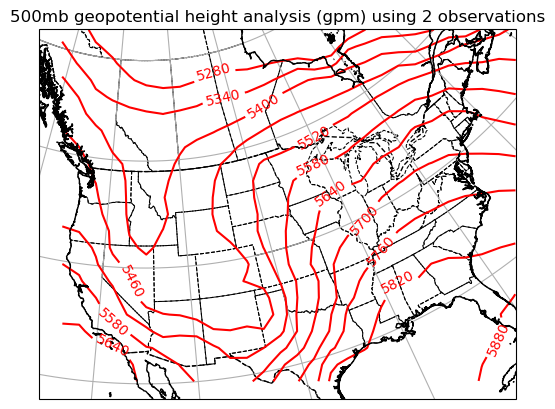

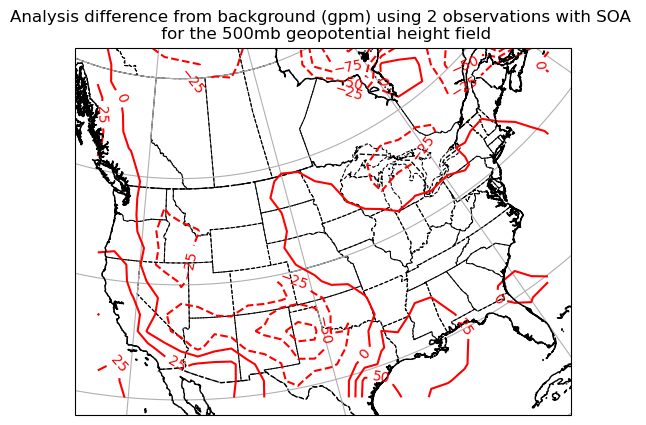

THE RMS OF using 2 points is: 51.7507 gpm


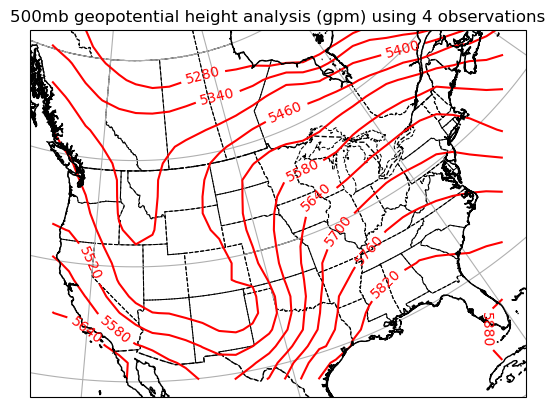

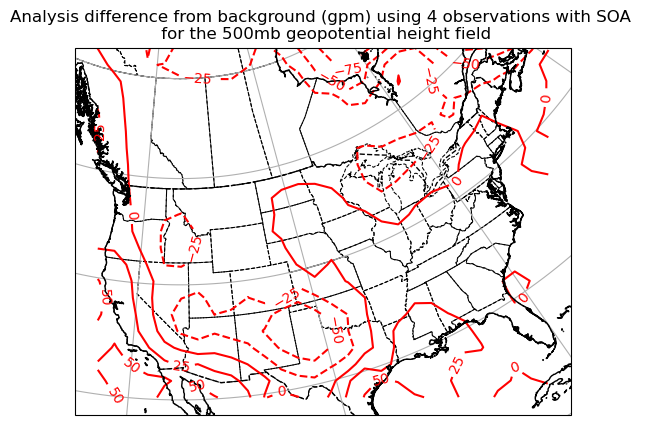

THE RMS OF using 4 points is: 49.848 gpm


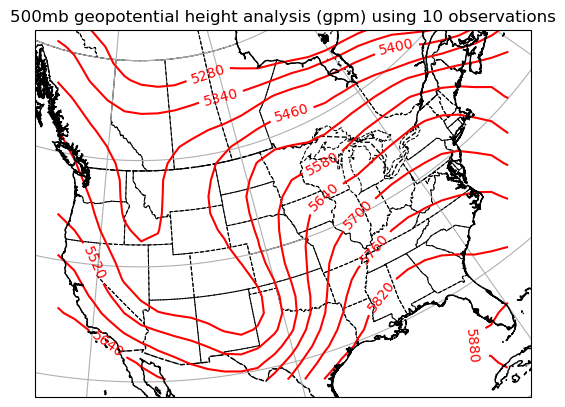

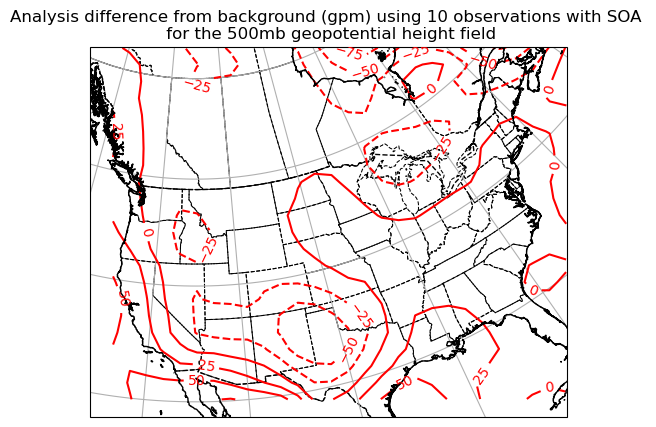

THE RMS OF using 10 points is: 50.9414 gpm


In [6]:
mainCode(2)
mainCode(4)
mainCode(10)

In [7]:
'''
1. 
Similar to the previous analysis methods in the course, there is a large trough centered over the western US, with a ridge to its east. 
There are tight gradients in the height contours between the trough and the ridge. 
All three (2,4,and 10 point) analyses have a notable negative tilt to the trough.
The analyses for the 2-point and 4-point cases have a few notable kinks in the height contours.


2. There are notable kinks in the analysis for the 2-point and 4-point analyses. The analyses are for the most part, grossly similar. 
The major differences are small scale shortwaves and kinks in the height contours. 
The 10-point analysis is the smoothest of the three. As seen in the analysis incrememnt fields (analysis - background), the greatest changes are in the 
center of low over NW Texas/New Mexico, and along the edges of the domain. Another region of large change from the background field (not plotted) of the
three analyses is the large extension of the 5400 line into Idaho. The 10-point analysis is smoother as more information is added with 10 observations
than just using 2 or 4 observations.


3. The 10-point analysis is the smoothest of the three. The first two have notable kinks in the height contours.
The RMS values of the analyses are all similar. The differences between the RMS values are small compared to the 
range of values for typical midlatitude synoptic scale 500mb height. This is desirable, as the 10-point analysis looks more physically realistic. 
This is since more information is added with 10 observations than just using 2 or 4 observations. 
'''

'\n1. The analyses for the 2-point and 4-point cases have a few notable kinks in the height contours.\nSimilar to the previous analysis methods in the course, there is a large trough centered over the western US, with a ridge to its east. \nAll three (2,4,and 10 point) analyses have a notable negative tilt to the trough. \n\n2. There are notable kinks in the analysis for the 2-point and 4-point analyses. The 10-point analysis is the smoothest of the three. \n\n3. The 10-point analysis is the smoothest of the three. The first two have notable kinks in the height contours.\nThe RMS values of the analyses are all similar. The differences between the RMS values are small compared to the \nrange of values for typical midlatitude synoptic scale 500mb height\n\n'